In [ ]:
#!pip install orbit-ml

In [ ]:
#!pip install yfinance

In [ ]:
#!pip install prophet

In [ ]:
#!pip install sktime[all_extras]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 4)


##Данные 

Проверять предсказания будем на свежих данных.

Среднемесячная номинальная начисленная заработная плата работников в целом по экономике Российской Федерации в 1991-2021 гг.

https://rosstat.gov.ru/labor_market_employment_salaries

In [ ]:
df=pd.read_excel('https://rosstat.gov.ru/storage/mediabank/tab1.xlsx')

In [ ]:
df

,Среднемесячная номинальная начисленная заработная плата работников по полному кругу организаций,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,в целом по экономике Российской Федерации в 19...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Рублей (до 1998г. – тыс. рублей),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,В среднем,В среднем за кварталы,NaN,NaN,NaN,Янв.,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сент.,Октябрь,Ноябрь,Декабрь
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,I,II,III,IV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1991,0.55,…,…,…,…,0.31,0.29,0.34,0.37,0.44,0.49,0.54,0.55,0.61,0.70,0.84,1.20
7,1992,6,2.10,4,6.30,12.10,1.40,2,2.70,3.10,3.70,5.10,5.50,5.90,7.40,8.90,10.60,16.10
8,1993,58.70,19.40,38.50,67.40,109.50,15.30,19.10,23.60,30.60,37.50,47.40,56,65.40,80.90,93,101.50,141.20
9,1994,220.40,148.10,187.50,232.30,298.60,134.20,144.70,164.80,171.50,183.50,207.50,221,232.80,253.20,265,281.60,354.20


In [ ]:
df=df.iloc[6:37,6:] #Убираем заголовки и комментарии

In [ ]:
import datetime as DT
index_date = pd.date_range(
                          start='1991-01-01',
                          periods=12*31, # до 2021 года
                          freq='M'
                            )

df_date=pd.Series()
for i in range(len(df)):
  df_date=df_date.append(pd.Series(df.iloc[i:i+1].values[0]))

df=pd.DataFrame(df_date)
df=df.set_index(index_date)
df=df.rename(columns={df.columns[0]:'salary'})
df=df.dropna()
df=df.astype('float')


df.head()

,salary
1991-01-31,0.31
1991-02-28,0.29
1991-03-31,0.34
1991-04-30,0.37
1991-05-31,0.44


<AxesSubplot:>

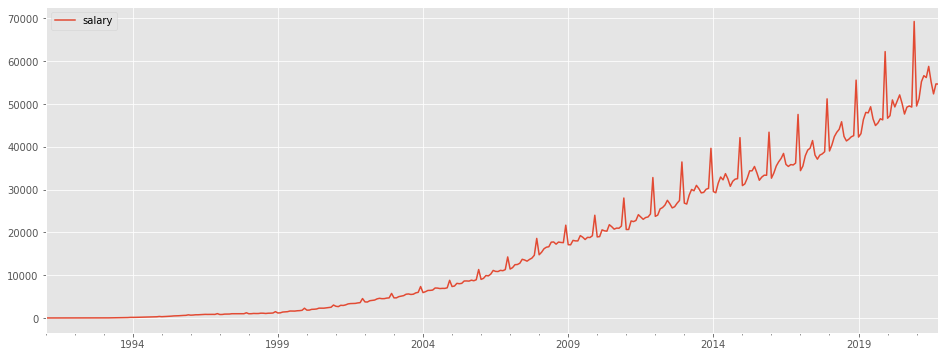

In [ ]:
plt.rcParams['figure.figsize'] = (16, 6)
df.plot()

## Начнем с трех простых моделей прогноза цены

### 1. Прогнозирование средним (Mean Constant Model)
### 2. Линейная модель (Linear Trend Model)
### 3. Линейная модель с регрессий (Linear Regression Model)

### Логарифмическое преобразование данных (Частный случай Бокса кокса)
Логарифмирование помогает стабилизировать разброс значений.

<AxesSubplot:ylabel='Frequency'>

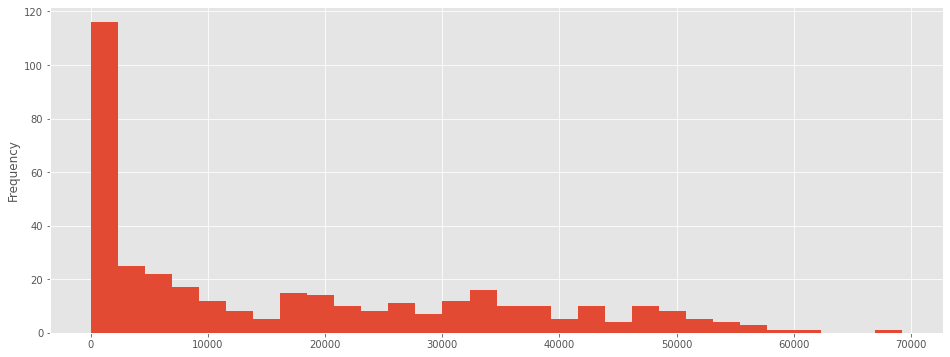

In [ ]:
df.salary.plot(kind = "hist", bins = 30)

При визуализации можем заметить, что есть данные, далеко отстающие от среднего значения, что может искажать модель регрессии. Наша задача минимизировать влияние таких данных. Желательно не исключая их.
В этом случае самый распространенный вариант действия - логарифмирование переменной.

In [ ]:
df['salaryLog'] = np.log(df.salary)
df.head()

,salary,salaryLog
1991-01-31,0.31,-1.18
1991-02-28,0.29,-1.22
1991-03-31,0.34,-1.09
1991-04-30,0.37,-0.99
1991-05-31,0.44,-0.83


<AxesSubplot:ylabel='Frequency'>

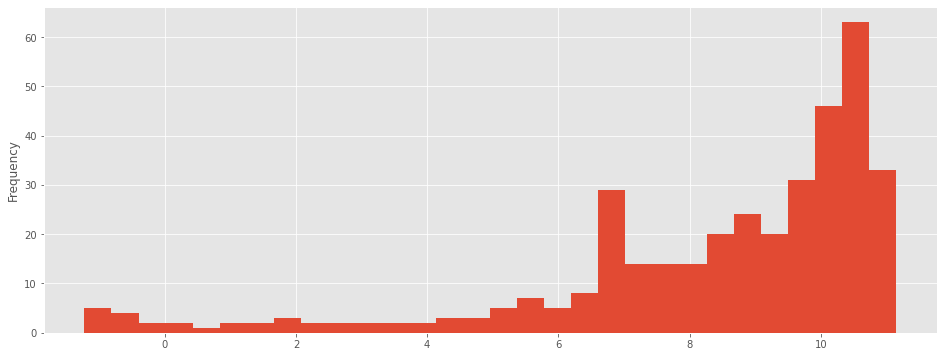

In [ ]:
df.salaryLog.plot(kind = "hist", bins = 30)

Lambda value used for Transformation: 0.2764344353116669


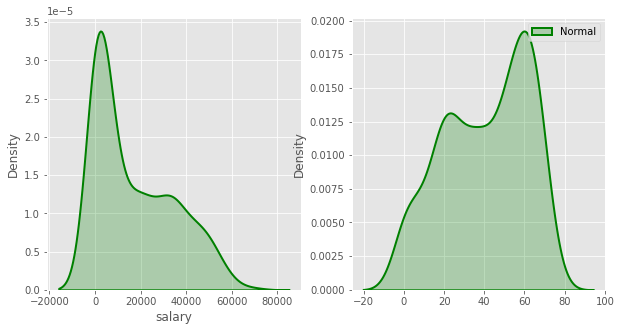

In [ ]:
# Python3 code to show Box-cox Transformation
# of non-normal data
# import modules
import numpy as np
from scipy import stats
# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
# generate non-normal data (exponential)
original_data = df.salary
# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(original_data)
# creating axes to draw plots
fig, ax = plt.subplots( 1 , 2 )
# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(original_data, hist = False , kde = True ,
kde_kws = { 'shade' : True , 'linewidth' : 2 },
label = "Non-Normal" , color = "green" , ax = ax[ 0 ])
sns.distplot(fitted_data, hist = False , kde = True ,
kde_kws = { 'shade' : True , 'linewidth' : 2 },
label = "Normal" , color = "green" , ax = ax[ 1 ])
# adding legends to the subplots
plt.legend(loc = "upper right" )
# rescaling the subplots
fig.set_figheight( 5 )
fig.set_figwidth( 10 )
print (f"Lambda value used for Transformation: {fitted_lambda}" )

In [ ]:
df['salaryBC'] = fitted_data

df.head()

,salary,salaryLog,salaryBC
1991-01-31,0.31,-1.18,-1.01
1991-02-28,0.29,-1.22,-1.04
1991-03-31,0.34,-1.09,-0.94
1991-04-30,0.37,-0.99,-0.86
1991-05-31,0.44,-0.83,-0.74


In [ ]:
#Function
def invboxcox(y,ld):
   if ld == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(ld*y+1)/ld))

df['salaryinvBC'] = invboxcox(fitted_data, fitted_lambda)

<AxesSubplot:>

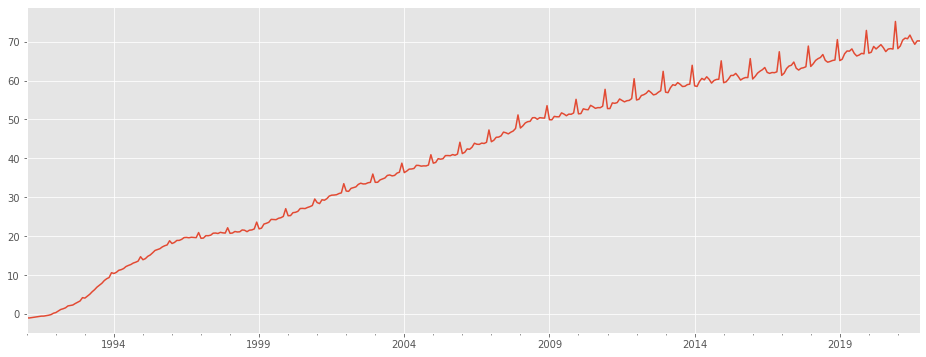

In [ ]:
df.salaryBC.plot()

In [ ]:
query_train=df.index<pd.to_datetime('2020-01-01')
query_test=df.index>=pd.to_datetime('2020-01-01')


df_train=df.loc[query_train]
df_test=df.loc[query_test]

## 1.1. Прогнозирование средним 

In [ ]:
df['salaryMean'] = df.salary.mean()

<AxesSubplot:>

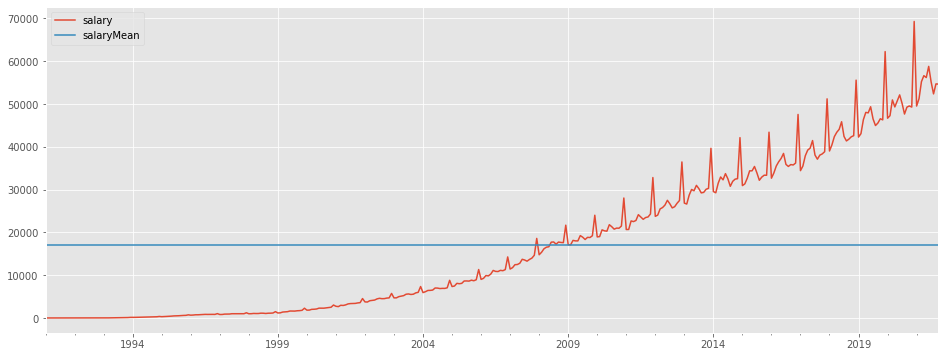

In [ ]:
df.plot(kind="line", y = ["salary", "salaryMean"])

**Как мерить качество?**

Чтобы обучать регрессионные модели, нужно определиться, как именно измеряется качество предсказаний.   
Будем использовать метрику RMSE (Root Mean Squared Error) - корень среднего квадрата отклонения.

$$RMSE = \sqrt{ \Sigma  (\hat{y} - y)^2/n}) $$ , 
где $\hat{y}$ это предсказанное значение y

### Метрики качества прогноза

**1. (R)MSE ((Root) Mean Squared Error)**

$$ L(\hat{y}, y) = \frac{1}{N}\sum\limits_{n=1}^N (y_n - \hat{y}_n)^2$$

**2. MAE (Mean Absolute Error)**

$$ L(\hat{y}, y) = \frac{1}{N}\sum\limits_{n=1}^N |y_n - \hat{y}_n|$$

**3. RSE (Relative Squared Error)**

$$ L(\hat{y}, y) = \sqrt\frac{\sum\limits_{n=1}^N (y_n - \hat{y}_n)^2}{\sum\limits_{n=1}^N (y_n - \bar{y})^2}$$

**4. RAE (Relative Absolute Error)**

$$ L(\hat{y}, y) = \frac{\sum\limits_{n=1}^N |y_n - \hat{y}_n|}{\sum\limits_{n=1}^N |y_n - \bar{y}|}$$

**5. MAPE (Mean Absolute Persentage Error)**

$$ L(\hat{y}, y) = \frac{100}{N} \sum\limits_{n=1}^N\left|\frac{ y_n - \hat{y}_n}{y_n}\right|$$


**6. RMSLE (Root Mean Squared Logarithmic Error)**

$$ L(\hat{y}, y) = \sqrt{\frac{1}{N}\sum\limits_{n=1}^N(\log(y_n + 1) - \log(\hat{y}_n + 1))^2}$$

In [ ]:
from sklearn.metrics import mean_squared_error

model_mean_RMSE=np.sqrt(mean_squared_error(df.loc[query_test].salary, df.loc[query_test].salaryMean))

Results = pd.DataFrame(columns = ["Model", "RMSE"])

Results.loc[0,"Model"] = "Mean"
Results.loc[0,"RMSE"] = model_mean_RMSE
Results.head()


,Model,RMSE
0,Mean,35779.40


## 1.2. Линейная модель

Построим линейную зависиммость между priceModLog and time.   
Регрессия от времени
Уравнение регрессии строится с помощью метода наименьших квадратов.

In [ ]:
df['timeIndex']=np.arange(len(df))

In [ ]:
model_linear = smf.ols('salary ~ timeIndex', data = df).fit()

model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     3211.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):          7.17e-184
Time:                        05:32:28   Log-Likelihood:                -3714.6
No. Observations:                 370   AIC:                             7433.
Df Residuals:                     368   BIC:                             7441.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.117e+04    576.925    -19.360      0.000   -1.23e+04      -1e+04
timeIndex    153.3596      2.706     56.670      0.000     148.038     158.681
==============================================================================
Omnibus:                       39.800   Durbin-Watson:                   0.324
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.501
Skew:                           0.848   Prob(JB):                     1.78e-11
Kurtosis:                       3.576   Cond. No.                         426.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
model_linear.params

Intercept   -11169.52
timeIndex      153.36
dtype: float64

In [ ]:
model_linear_pred = model_linear.predict()

df["salaryLinear"] = model_linear_pred

<AxesSubplot:>

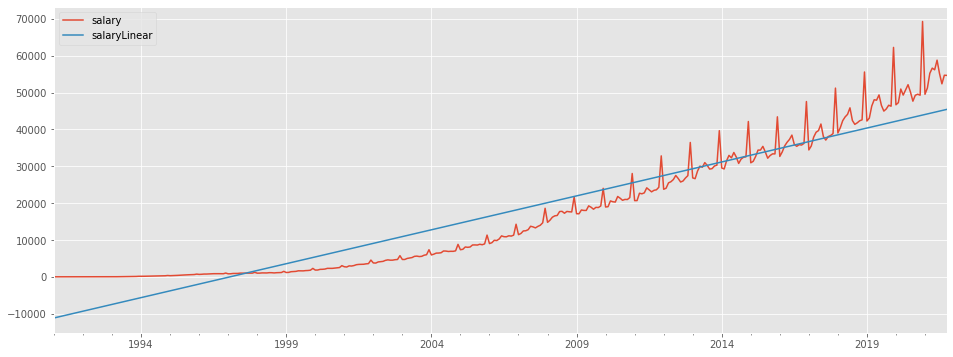

In [ ]:
df[['salary', 'salaryLinear']].plot()

In [ ]:
model_linear_RMSE = np.sqrt(mean_squared_error(df.loc[query_test].salary, df.loc[query_test].salaryLinear))

In [ ]:
Results.loc[1,"Model"] = "Linear"
Results.loc[1,"RMSE"] = model_linear_RMSE
Results.head()

,Model,RMSE
0,Mean,35779.40
1,Linear,9822.31


## 2 Выделение тренда и сезонности

При работе с временными рядами выделяют два действия:
- Дифференцирование - расчет разницы с определенным временным лагом
- Декомпозиция - моделирование как тренда, так и сезонности и удаление их из модели.

Предположим, что у вас имеются ежемесячные данные о пассажиропотоке на международных авиалиниях.  
Объем пассажиропотока имеет во времени возрастающий линейный тренд, и в ряде имеется ежегодно повторяющаяся закономерность - сезонность (большинство перевозок приходится на летние месяцы, кроме того, имеется пик меньшей высоты в районе декабрьских каникул). 
Цель декомпозиции как раз и состоит в том, чтобы отделить эти компоненты, то есть разложить ряд на составляющую тренда, сезонную компоненту и оставшуюся нерегулярную составляющую. 

То есть каждый уровень временного ряда формируется под воздействием большого числа факторов, которые условно можно подразделить на три группы:
- факторы, формирующие тенденцию ряда
- факторы, формирующие циклические колебания ряда
- случайные факторы  

Рассмотрим воздействие каждого фактора на временной ряд в отдельности.  
Большинство временных рядов экономических показателей имеют тенденцию, 
характеризующую совокупное долговременное воздействие множества факторов на динамику изучаемого показателя.  
Все эти факторы, взятые в отдельности, могут оказывать разнонаправленное воздействие на исследуемый показатель. Однако в совокупности они формируют его возрастающую или убывающую тенденцию

В большинстве случаев фактический уровень временного ряда можно представить как сумму или произведение трендовой, циклической и случайной компонент. Модель, в которой временной ряд представлен как сумма перечисленных компонент, называется **аддитивной** моделью временного ряда. Модель, в которой временной ряд представлен как произведение перечисленных компонент, называется **мультипликативной** моделью временного ряда. 

**Аддитивная модель** 
$${Y_t} = t (trend) + s (seasonality) + r (residual)$$

![](https://miro.medium.com/max/1360/0*JWWglnH4RBR-SbxC.png)

**Мультипликативная модель** 
$${Y_t} = t (trend) * s (seasonality) * r (residual)$$

![](https://anomaly.io/wp-content/uploads/2015/12/multiplicative-model.png)

Как видим, отличие мультипликативной модели от аддитивной состоит в том, 
что в мультипликативной модели сезонная и случайная составляющие определены в виде относительных величин (коэффициентов), 
а в аддитивной модели – в виде абсолютных величин.   
Эти модели в практических расчетах дадут близкие результаты, если амплитуда колебаний уровней ряда слабо изменяется во времени

### Декомпозиция 
Декомпозируем наш временной ряд на тренд и сезонность

<Figure size 1152x720 with 0 Axes>

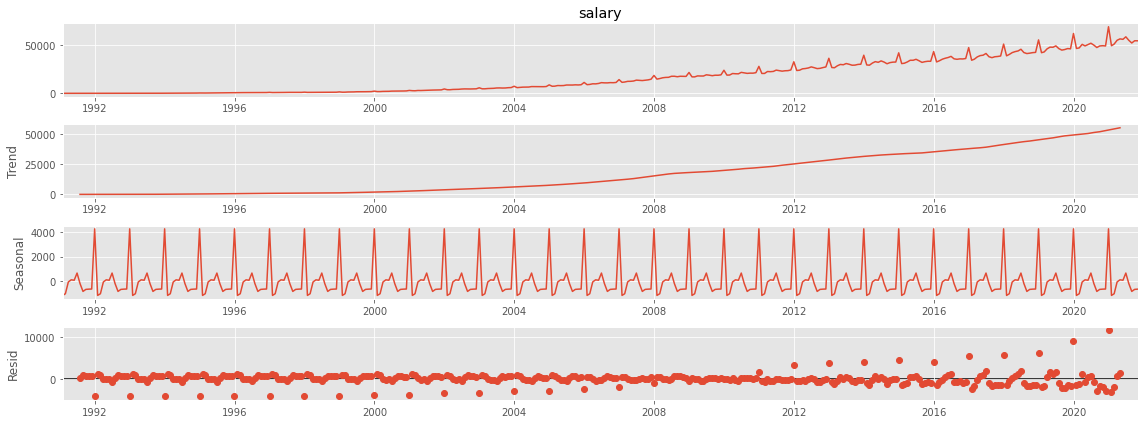

<Figure size 1152x720 with 0 Axes>

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df.salary, model = "additive")

decomposition.plot()
plt.figure(figsize=(16,10))

## 3 Стационарность ряда

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как стационарность.  
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках:

![](https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png)  
Временной ряд справа не является стационарным, так как его матожидание со временем растёт

![](https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png)  
Здесь не повезло с дисперсией — разброс значений ряда существенно варьируется в зависимости от периода

![](https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png)  
На последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций



Почему стационарность так важна?  
По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

In [ ]:
test = sm.tsa.adfuller(df.salary)
print('adf: ', test[0])
print('p-value: ', test[1])

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  3.385620264101126
p-value:  1.0


### Расчет лагов
Представим временной ряд в виде последовательности разницы между значениями.  
Рассчитаем лаги, выведем их на графике

<AxesSubplot:xlabel='salary_shift', ylabel='salaryBC'>

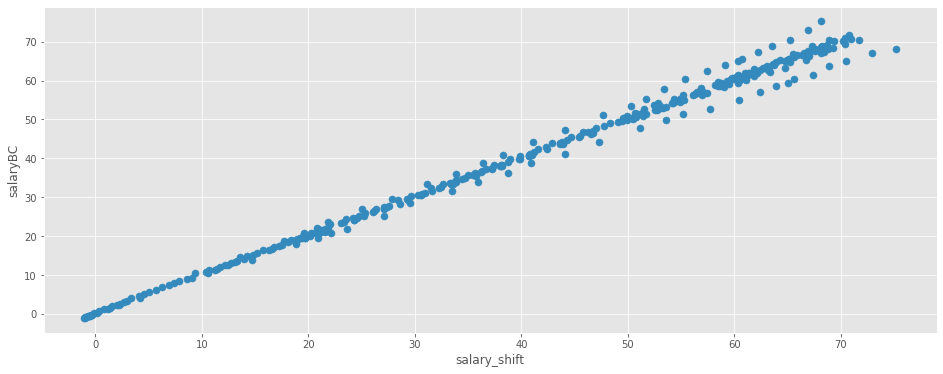

In [ ]:
# Рассчитаем лаги
df["salary_shift"] = df.salaryBC.shift()

# Выведем на графике priceModLog и priceModLogShift1
df.plot(kind= "scatter", y = "salaryBC", x = "salary_shift", s = 50)

In [ ]:
df["salarydiff"] = df.salaryBC - df.salary_shift

<AxesSubplot:>

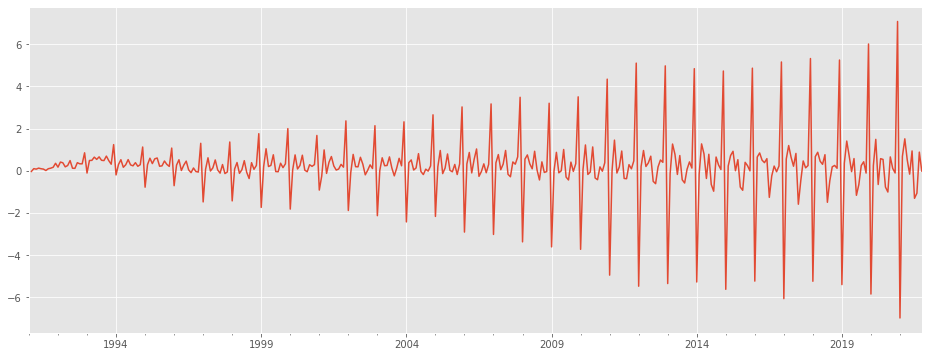

In [ ]:
df.salarydiff.plot()

In [ ]:
test = sm.tsa.adfuller(df.salarydiff.dropna())
print('adf: ', test[0])
print('p-value: ', test[1])

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -2.807942725653011
p-value:  0.057148132690850464


## 4 Построение модели АRIMA

Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.  
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:  
- p — порядок компоненты AR
- d — порядок интегрированного ряда (порядок разности временного ряда)
- q — порядок компонетны MA  


Параметр d равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную (ACF) и частично автокорреляционную (PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.  

Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: acf и pacf.  
Можем построить графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов.

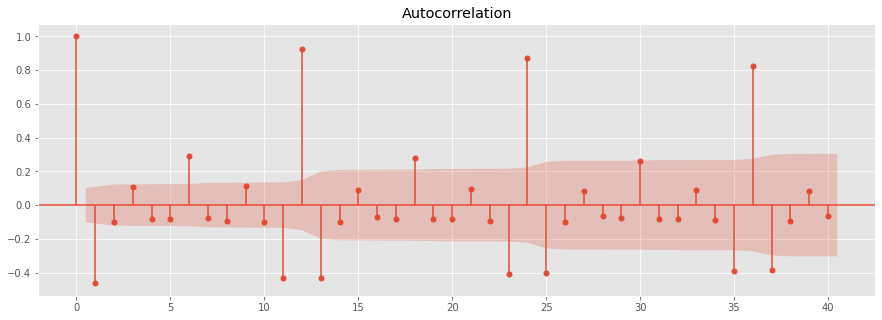

In [ ]:
# ACF и PACF 
from statsmodels.tsa.stattools import acf, pacf

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sm.graphics.tsa.plot_acf(df.salarydiff.dropna(), ax, lags=40)
plt.show()

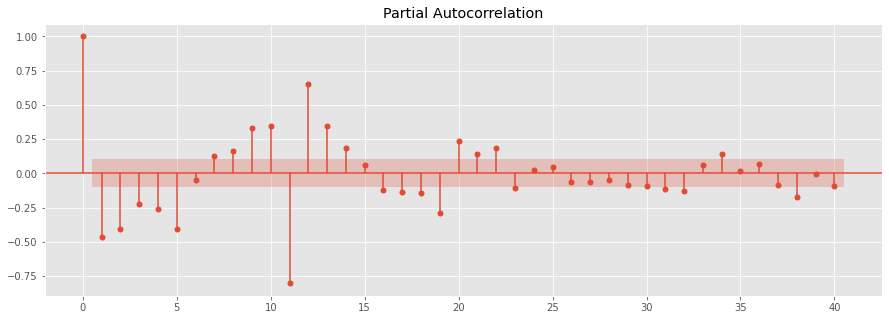

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sm.graphics.tsa.plot_pacf(df.salarydiff.dropna(), ax, lags=40)
plt.show()

## Построим модель ARIMA 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# ARIMA Model (1,0,1)
model_ARIMA = ARIMA(df.salarydiff.dropna(), order=(5,0,1))

In [ ]:
results_ARIMA = model_ARIMA.fit()

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pd.Series(df.salary.iloc[0], index=df.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

df['salaryARIMA'] = invboxcox(predictions_ARIMA_log, fitted_lambda)

df.head()

,salary,salaryLog,salaryBC,salaryinvBC,salaryMean,timeIndex,salaryLinear,salary_shift,salarydiff,salaryARIMA
1991-01-31,0.31,-1.18,-1.01,0.31,17125.33,0,-11169.52,nan,nan,1.34
1991-02-28,0.29,-1.22,-1.04,0.29,17125.33,1,-11016.16,-1.01,-0.03,1.60
1991-03-31,0.34,-1.09,-0.94,0.34,17125.33,2,-10862.80,-1.04,0.10,2.07
1991-04-30,0.37,-0.99,-0.86,0.37,17125.33,3,-10709.44,-0.94,0.08,2.72
1991-05-31,0.44,-0.83,-0.74,0.44,17125.33,4,-10556.08,-0.86,0.13,3.60


<AxesSubplot:>

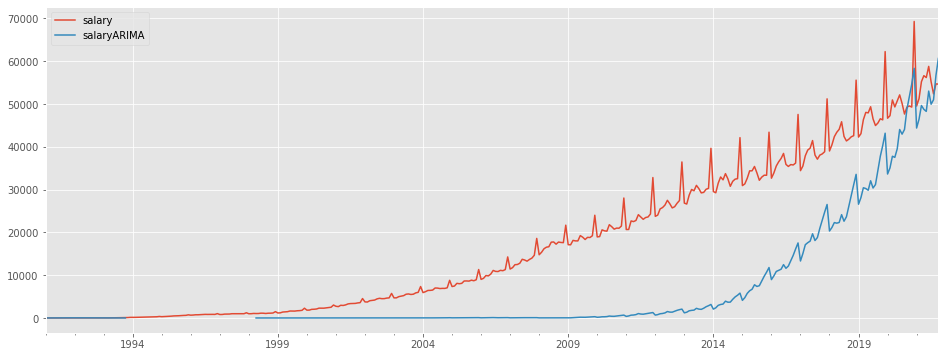

In [ ]:
df[['salary','salaryARIMA']].plot()

In [ ]:
model_arima_RMSE = np.sqrt(mean_squared_error(df.loc[query_test].salary, df.loc[query_test].salaryARIMA))

In [ ]:
Results.loc[2,"Model"] = "ARIMA"
Results.loc[2,"RMSE"] = model_arima_RMSE
Results.head()

,Model,RMSE
0,Mean,35779.40
1,Linear,9822.31
2,ARIMA,7826.12


![](http://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/09/image2.png)

Интервалы прогнозирования так же важны, как и сам точечный прогноз, и всегда должны быть включены в ваши прогнозы. Интервалы прогнозирования обычно зависят от того, каким объемом данных мы располагаем, насколько велики вариации в этих данных, насколько далеко мы прогнозируем и какой подход к прогнозированию используется.



# Sktime

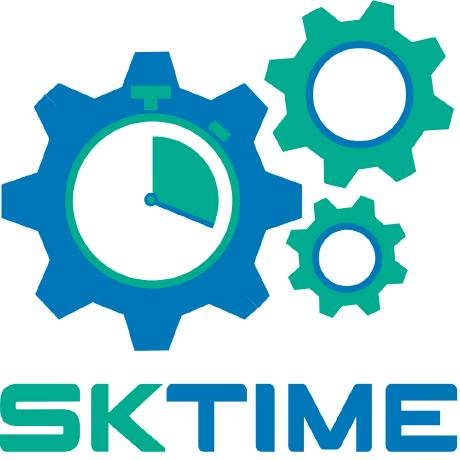

Ссылка: https://github.com/alan-turing-institute/sktime

# AutoARIMA

AutoARIMA осуществляет автоматический подбор параметров модели (S)ARIMA. ARIMA - это комбинация авторегрессионной модели AR, скользящего среднего MA и дифференцирования временного ряда I. Объяснить эту модель картинкой или парой формул не получится :( Поэтому приведем ссылку на отличный учебник: https://otexts.com/fpp3/arima.html


(S)ARIMA задается семью параметрами: (p, d, q) для прогноза очищенного от сезонности ряда, (P, D, Q)m для прогноза сезонной компоненты временного ряда. А именно:

- p - число предыдущих значений ряда в авторегрессионной AR модели;
- d - порядок дифференцирования входного ряда;
- q - порядо MA модели скользящего среднего;
- P - число предыдущих значений ряда в авторегрессионной AR модели для сезонной компоненты;
- D - порядок дифференцирования входного ряда для сезонной компоненты;
- Q - порядо MA модели скользящего среднего для сезонной компоненты;
- m - число измерений в одном периоде. В нашем случае m=52.

Документация: https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html#sktime.forecasting.arima.AutoARIMA

наш первый шаг - привести наш верменной ряд к нужному формату. 

In [ ]:
trains_ts = pd.Series(data=df.loc[query_train].salary, index=df.loc[query_train].index)
trains_ts.index.freq="M"

In [ ]:
trains_ts

1991-01-31       0.31
1991-02-28       0.29
1991-03-31       0.34
1991-04-30       0.37
1991-05-31       0.44
               ...   
2019-08-31   44961.00
2019-09-30   45541.00
2019-10-31   46549.00
2019-11-30   46285.00
2019-12-31   62239.00
Freq: M, Name: salary, Length: 348, dtype: float64

In [ ]:
%%time
from sktime.forecasting.arima import AutoARIMA

# инициализация модели
# ВНИМАНИЕ: если взять более широкие границы параметров, то обучение займет очень много времени и ОЗУ (AutoARIMA не болей)
forecaster = AutoARIMA(start_p=1, d=None, start_q=0, 
                       max_p=4, max_d=1, max_q=2, 
                       start_P=1, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=1, 
                      sp=12, suppress_warnings=True, stepwise=False, n_jobs=-1)

# обучение модели
forecaster.fit(trains_ts)

CPU times: user 2.09 s, sys: 1.99 s, total: 4.08 s
Wall time: 44.4 s


In [ ]:
# посмотрим какие параметры являются оптимальными
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -2471.523
Date:                              Fri, 14 Jan 2022   AIC                           4955.045
Time:                                      05:33:16   BIC                           4977.930
Sample:                                           0   HQIC                          4964.169
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9337      3.193      0.292      0.770      -5.325       7.192
ar.L1         -0.3008      0.034     -8.777      0.000      -0.368      -0.234
ar.L2         -0.2440      0.048     -5.032      0.000      -0.339      -0.149
ar.S.L12       0.9738      0.028     35.240      0.000       0.920       1.028
ma.S.L12      -0.8545      0.055    -15.667      0.000      -0.961      -0.748
sigma2      1.468e+05   6614.863     22.196      0.000    1.34e+05     1.6e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               881.58
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):             188.70   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Теперь переведем данные тестирования в нужный формат, чтобы мы смогли сделать прогноз. И, собственно, сделаем прогноз!

In [ ]:
from sktime.forecasting.base import ForecastingHorizon

# pd.DataFrame -> pd.Series
test_ts = pd.Series(data=df.loc[query_test].salary.values, index=df.loc[query_test].index.values)
test_ts.index.freq="M"

# о да! для погноза свой формат
fh = ForecastingHorizon(test_ts.index, is_relative=False)

In [ ]:
# получаем прогноз и доверительные интервалы
y_pred, y_intervals = forecaster.predict(fh, return_pred_int=True)

In [ ]:
# так выглядит прогноз
y_pred.head()

2020-01-31   47782.34
2020-02-29   48214.93
2020-03-31   51950.03
2020-04-30   53788.91
2020-05-31   53578.19
dtype: float64

In [ ]:
# так выглядят доверительные интервалы
y_intervals.head()

,lower,upper
2020-01-31,47031.31,48533.36
2020-02-29,47298.52,49131.33
2020-03-31,50946.16,52953.90
2020-04-30,52667.58,54910.24
2020-05-31,52350.13,54806.24


In [ ]:
predicted_df_arima = pd.DataFrame(index=df.loc[query_test].index.values)
#predicted_df_arima['mount'] = df.loc[query_test].index.values
predicted_df_arima['salaryAVTOARIMA_5'] = y_intervals['lower'].values
predicted_df_arima['salaryAVTOARIMA'] = y_pred.values
predicted_df_arima['salaryAVTOARIMA_95'] = y_intervals['upper'].values

predicted_df_arima.head()

,salaryAVTOARIMA_5,salaryAVTOARIMA,salaryAVTOARIMA_95
2020-01-31,47031.31,47782.34,48533.36
2020-02-29,47298.52,48214.93,49131.33
2020-03-31,50946.16,51950.03,52953.90
2020-04-30,52667.58,53788.91,54910.24
2020-05-31,52350.13,53578.19,54806.24


In [ ]:
df=df.join(predicted_df_arima['salaryAVTOARIMA'])
df=df.join(predicted_df_arima['salaryAVTOARIMA_5'])
df=df.join(predicted_df_arima['salaryAVTOARIMA_95'])
df

,salary,salaryLog,salaryBC,salaryinvBC,salaryMean,timeIndex,salaryLinear,salary_shift,salarydiff,salaryARIMA,salaryAVTOARIMA,salaryAVTOARIMA_5,salaryAVTOARIMA_95
1991-01-31,0.31,-1.18,-1.01,0.31,17125.33,0,-11169.52,nan,nan,1.34,nan,nan,nan
1991-02-28,0.29,-1.22,-1.04,0.29,17125.33,1,-11016.16,-1.01,-0.03,1.60,nan,nan,nan
1991-03-31,0.34,-1.09,-0.94,0.34,17125.33,2,-10862.80,-1.04,0.10,2.07,nan,nan,nan
1991-04-30,0.37,-0.99,-0.86,0.37,17125.33,3,-10709.44,-0.94,0.08,2.72,nan,nan,nan
1991-05-31,0.44,-0.83,-0.74,0.44,17125.33,4,-10556.08,-0.86,0.13,3.60,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,58782.00,10.98,71.68,58782.00,17125.33,365,44806.75,70.74,0.94,53012.20,61134.17,57941.36,64326.99
2021-07-31,55170.00,10.92,70.37,55170.00,17125.33,366,44960.11,71.68,-1.31,49939.78,58021.41,54666.90,61375.92
2021-08-31,52355.00,10.87,69.31,52355.00,17125.33,367,45113.46,70.37,-1.06,50992.95,56306.14,52796.23,59816.05
2021-09-30,54687.00,10.91,70.19,54687.00,17125.33,368,45266.82,69.31,0.88,56683.14,56915.03,53257.14,60572.92


<AxesSubplot:>

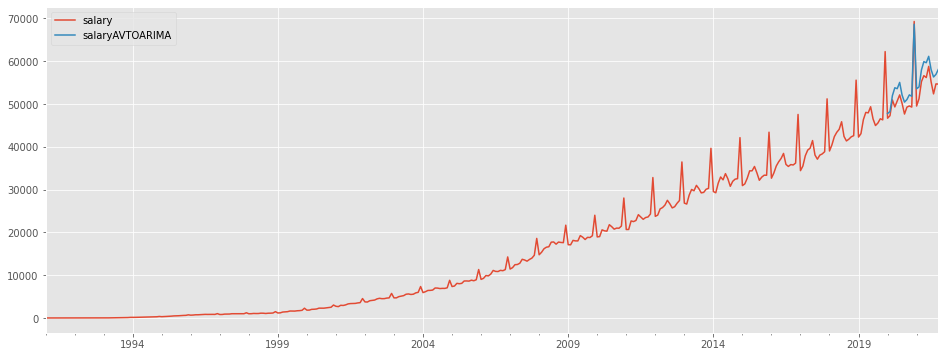

In [ ]:
df[['salary', 'salaryAVTOARIMA']].plot()

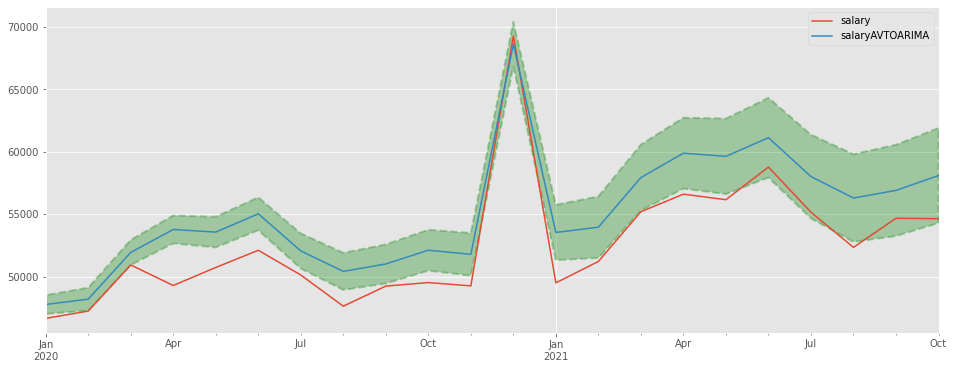

In [ ]:
df.loc[query_test][['salary', 'salaryAVTOARIMA']].plot()

plt.fill_between(df.loc[query_test].index, df.loc[query_test].salaryAVTOARIMA_95, df.loc[query_test].salaryAVTOARIMA_5,                 
                facecolor='g',
                alpha = 0.3,
                color = 'green',
                linewidth = 2,
                linestyle = '--')

In [ ]:
model_autoarima_RMSE = np.sqrt(mean_squared_error(df.loc[query_test].salary, df.loc[query_test].salaryAVTOARIMA))

In [ ]:
Results.loc[3,"Model"] = "AVTOARIMA"
Results.loc[3,"RMSE"] = model_autoarima_RMSE
Results.head()

,Model,RMSE
0,Mean,35779.40
1,Linear,9822.31
2,ARIMA,7826.12
3,AVTOARIMA,2764.42


## Адаптивные модели

Скользящая средняя


<AxesSubplot:>

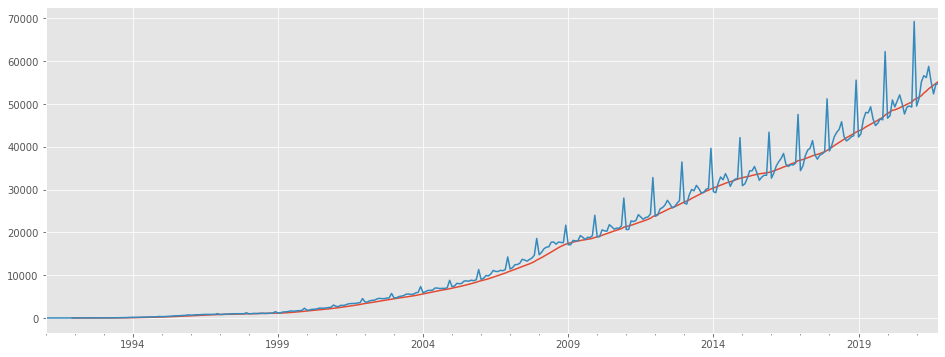

In [ ]:
df.salary.rolling(12).mean().plot()
df.salary.plot()

## Тройное экспоненциальное сглаживание 

Метод Хольта-Винтерса – это трехпараметрическая модель прогноза, которая учитывает:

*   сглаженный экспоненциальный ряд;
*   тренд;
* сезонность





https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [ ]:
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_predictions=ExponentialSmoothing(df.loc[query_train].salary,
                                       #trend='mul',
                                       seasonal='mul',
                                       seasonal_periods=12).fit().fittedvalues


In [ ]:
fitted_model = ExponentialSmoothing(df.loc[query_train].salary,
                                    #trend='mul',
                                    seasonal='mul',
                                    seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(24)

df['salaryExpSmt']=train_predictions.append(test_predictions)


<AxesSubplot:>

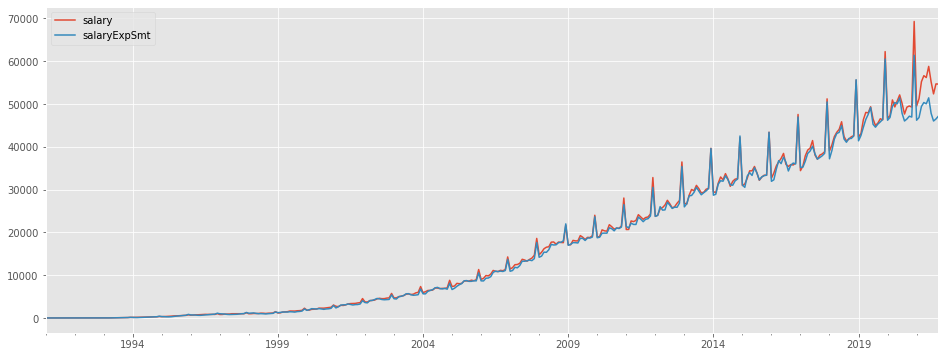

In [ ]:
df[['salary', 'salaryExpSmt']].plot()

In [ ]:
model_ExpSmt_RMSE = np.sqrt(mean_squared_error(df.loc[query_test].salary, df.loc[query_test].salaryExpSmt))

Results.loc[4,"Model"] = "ExpSmt"
Results.loc[4,"RMSE"] = model_ExpSmt_RMSE
Results.head()

,Model,RMSE
0,Mean,35779.40
1,Linear,9822.31
2,ARIMA,7826.12
3,AVTOARIMA,2764.42
4,ExpSmt,4797.04


[*********************100%***********************]  1 of 1 completed


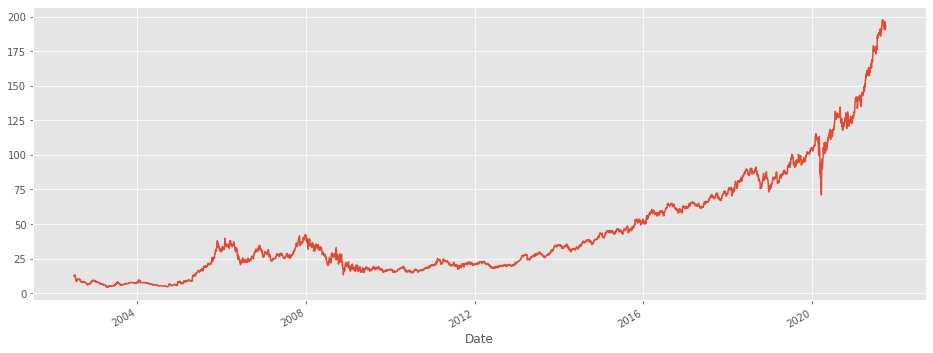

,salary,salaryLog,salaryBC,salaryinvBC,salaryMean,timeIndex,salaryLinear,salary_shift,salarydiff,salaryARIMA,salaryAVTOARIMA,salaryAVTOARIMA_5,salaryAVTOARIMA_95,salaryExpSmt,NDAQ
1991-01-31,0.31,-1.18,-1.01,0.31,17125.33,0,-11169.52,nan,nan,1.34,nan,nan,nan,0.31,12.00
1991-02-28,0.29,-1.22,-1.04,0.29,17125.33,1,-11016.16,-1.01,-0.03,1.60,nan,nan,nan,0.29,12.00
1991-03-31,0.34,-1.09,-0.94,0.34,17125.33,2,-10862.80,-1.04,0.10,2.07,nan,nan,nan,0.34,12.00
1991-04-30,0.37,-0.99,-0.86,0.37,17125.33,3,-10709.44,-0.94,0.08,2.72,nan,nan,nan,0.37,12.00
1991-05-31,0.44,-0.83,-0.74,0.44,17125.33,4,-10556.08,-0.86,0.13,3.60,nan,nan,nan,0.44,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,58782.00,10.98,71.68,58782.00,17125.33,365,44806.75,70.74,0.94,53012.20,61134.17,57941.36,64326.99,51433.46,175.80
2021-07-31,55170.00,10.92,70.37,55170.00,17125.33,366,44960.11,71.68,-1.31,49939.78,58021.41,54666.90,61375.92,47818.79,186.73
2021-08-31,52355.00,10.87,69.31,52355.00,17125.33,367,45113.46,70.37,-1.06,50992.95,56306.14,52796.23,59816.05,46020.57,195.78
2021-09-30,54687.00,10.91,70.19,54687.00,17125.33,368,45266.82,69.31,0.88,56683.14,56915.03,53257.14,60572.92,46493.56,193.02


In [ ]:
import yfinance as yf

# Get the data for the stock AAPL
data = yf.download('NDAQ','1991-01-01','2021-10-01')

# Plot the close price of the AAPL
data['Adj Close'].plot()
plt.show()

df['NDAQ']=data.asfreq('M', method='ffill').Close
df['NDAQ']=df['NDAQ'].fillna(method='bfill')
df['NDAQ']=df['NDAQ'].fillna(method='ffill')
df

# Prophet

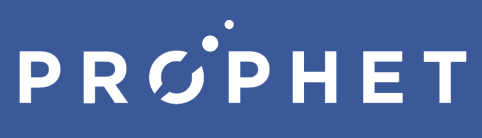

Ссылка: https://facebook.github.io/prophet/

https://habr.com/ru/company/ods/blog/323730/

Для начала нам необходимо привести наш временной ряд к нужному формату.

In [ ]:
df.head()

,salary,salaryLog,salaryBC,salaryinvBC,salaryMean,timeIndex,salaryLinear,salary_shift,salarydiff,salaryARIMA,salaryAVTOARIMA,salaryAVTOARIMA_5,salaryAVTOARIMA_95,salaryExpSmt,NDAQ
1991-01-31,0.31,-1.18,-1.01,0.31,17125.33,0,-11169.52,nan,nan,1.34,nan,nan,nan,0.31,12.00
1991-02-28,0.29,-1.22,-1.04,0.29,17125.33,1,-11016.16,-1.01,-0.03,1.60,nan,nan,nan,0.29,12.00
1991-03-31,0.34,-1.09,-0.94,0.34,17125.33,2,-10862.80,-1.04,0.10,2.07,nan,nan,nan,0.34,12.00
1991-04-30,0.37,-0.99,-0.86,0.37,17125.33,3,-10709.44,-0.94,0.08,2.72,nan,nan,nan,0.37,12.00
1991-05-31,0.44,-0.83,-0.74,0.44,17125.33,4,-10556.08,-0.86,0.13,3.60,nan,nan,nan,0.44,12.00


In [ ]:
train_df_prophet = df.loc[query_train].reset_index()[['index', 'salary', 'NDAQ']]
train_df_prophet.columns = ['ds', 'y', 'trend.NDAQ']

train_df_prophet.head()

,ds,y,trend.NDAQ
0,1991-01-31,0.31,12.00
1,1991-02-28,0.29,12.00
2,1991-03-31,0.34,12.00
3,1991-04-30,0.37,12.00
4,1991-05-31,0.44,12.00


In [ ]:
from prophet import Prophet

# инициализируем модель
model = Prophet(interval_width=0.9, seasonality_mode='multiplicative')

# добавляем регрессоры
model.add_regressor('trend.NDAQ')

# обучаем модель
model.fit(train_df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Теперь, мы готовы делать прогноз. Но перед этим нам нужно снова привести данные в нужный формат.

In [ ]:
future = df.loc[query_test].reset_index()[['index', 'salary', 'NDAQ']]
future.columns = ['ds', 'y', 'trend.NDAQ']

future.head()

,ds,y,trend.NDAQ
0,2020-01-31,46674.00,116.46
1,2020-02-29,47257.00,102.55
2,2020-03-31,50948.00,94.95
3,2020-04-30,49306.00,109.67
4,2020-05-31,50747.00,118.46


In [ ]:
# делаем прогноз на указанные даты
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-31,45186.10,44285.41,46040.42
1,2020-02-29,45436.33,44532.18,46392.33
2,2020-03-31,47256.74,46354.54,48103.10
3,2020-04-30,49263.43,48333.38,50155.69
4,2020-05-31,50204.35,49300.55,51154.91


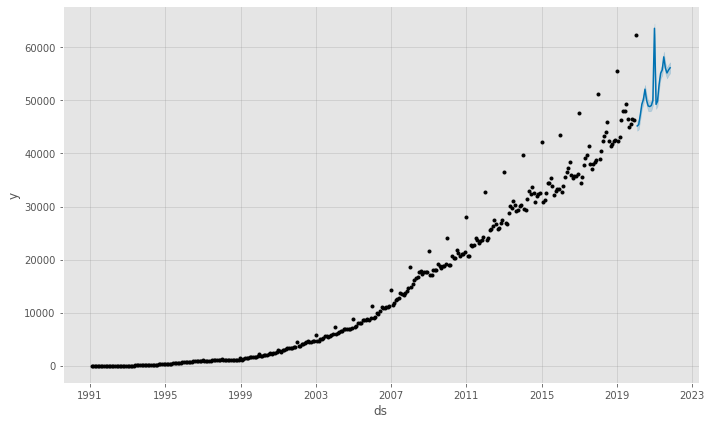

In [ ]:
# отображаем прогноз на требуемые даты
fig1 = model.plot(forecast)

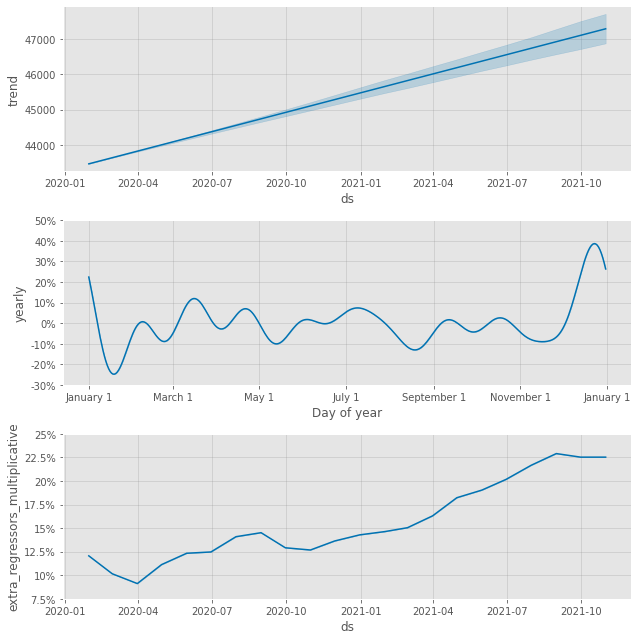

In [ ]:
# даже можем вывести компоненты прогноза
fig2 = model.plot_components(forecast)

<AxesSubplot:>

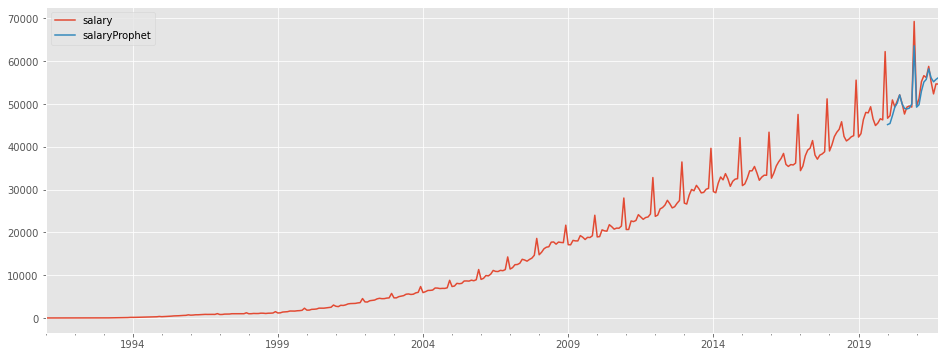

In [ ]:
df['salaryProphet']=forecast.set_index('ds')[['yhat']]

df[['salary', 'salaryProphet']].plot()


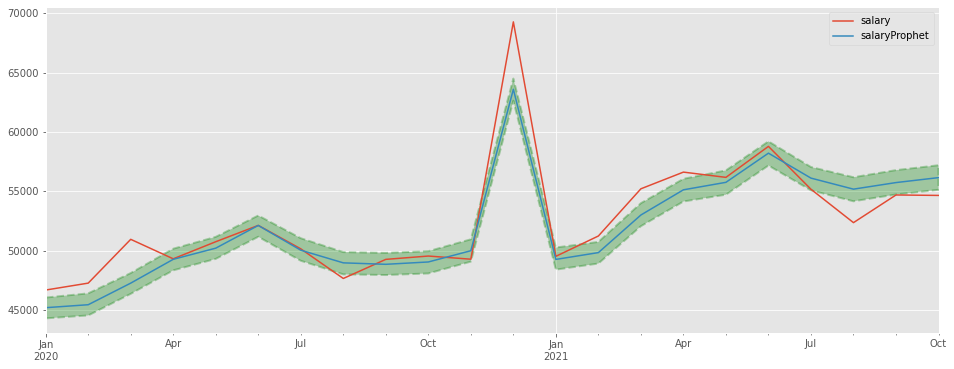

In [ ]:
df.loc[query_test][['salary', 'salaryProphet']].plot()

plt.fill_between(df.loc[query_test].index, forecast.yhat_upper, forecast.yhat_lower,                 
                facecolor='g',
                alpha = 0.3,
                color = 'green',
                linewidth = 2,
                linestyle = '--')

In [ ]:
model_Prophet_RMSE = np.sqrt(mean_squared_error(df.loc[query_test].salary, df.loc[query_test].salaryProphet))


In [ ]:
Results.loc[5,"Model"] = "Prophet"
Results.loc[5,"RMSE"] = model_Prophet_RMSE

Results


,Model,RMSE
0,Mean,35779.40
1,Linear,9822.31
2,ARIMA,7826.12
3,AVTOARIMA,2764.42
4,ExpSmt,4797.04
5,Prophet,1861.67


# Orbit 

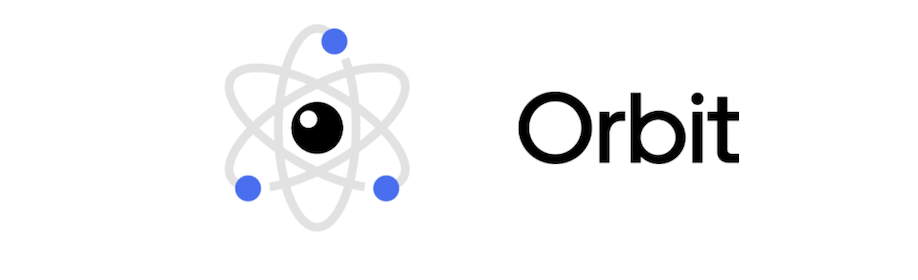

Сссылка: https://github.com/uber/orbit

# Damped Local Trend (DLT)

Уравнения модели для прогноза:

$$
y_t = \mu_t + s_t + r_t + \epsilon_t
$$
$$
\mu_t = g_t + l_{t-1} + \theta b_{t-1}
$$
$$
\epsilon_t \sim \text{Student}(\nu, 0, \sigma)
$$
$$
\sigma \sim \text{HalfCauchy}(0, \gamma_0)
$$

Уравнения для обновления:

$$
g_t = D(t)
$$
$$
l_t = \rho_l(y_t - g_t - s_t - r_t) + (1 - \rho_l)(l_{t-1}+\theta b_{t-1})
$$
$$
b_t = \rho_b(l_t - l_{t-1}) + (1 - \rho_b)\theta b_{t-1}
$$
$$
s_{t+m} = \rho_s(y_t - l_{t}-r_t) + (1 - \rho_s)s_t
$$
$$
r_{t} = \sum_{j}\beta_jx_{jt}
$$

где 
- $\rho_{l}$, $\rho_{b}$, $\rho_{s}$ - гиперпараметры модели; 
- $l_t$ - сглаженное значение временного ряда (англ. level); 
- $b_t$ - тренд временного ряда;
- $s_t$ - сезоннная компонента ряда; 
- $g_t$ - детерминированный процесс тренда; 
- $r_t$ - регрессор модели; 
- $\beta_j \sim N(\mu_j, \sigma_j^2)$ - коэффициенты регрессора;
- $x_{jt}$ - признаки наблюдений;


Источник: https://orbit-ml.readthedocs.io/en/stable/tutorials/dlt.html

Документация: https://orbit-ml.readthedocs.io/en/stable/orbit.models.html?highlight=DLTFull#orbit.models.dlt.DLTFull

In [ ]:
from orbit.models.lgt import LGT

# инициализируем модель
lgt = LGT(
    response_col='salary', 
    date_col='index',
    #regressor_col=['NDAQ'],
    seasonality=12,
)


# обучаем модель
lgt.fit(df=df.loc[query_train].reset_index())

# делаем прогноз
predicted_df = lgt.predict(df=df.loc[query_test].reset_index())

# выводим таблицу прогноза
predicted_df.head()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d372bb7bc77e1df83218127fc9dd707d NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,index,prediction_5,prediction,prediction_95
0,2020-01-31,46944.96,47429.21,48003.10
1,2020-02-29,47764.79,48363.70,49073.33
2,2020-03-31,50736.71,51317.84,51938.51
3,2020-04-30,52034.02,52669.02,53336.31
4,2020-05-31,51815.20,52473.56,53152.62


In [ ]:
# построим график прогноза с доверительными интервалами
from orbit.diagnostics.plot import plot_predicted_data


# plot_predicted_data(
#     training_actual_df=df.loc[query_train].reset_index(), predicted_df=predicted_df,
#     date_col=lgt.date_col, actual_col=lgt.response_col,
#     test_actual_df=df.loc[query_test].reset_index()
# )


<AxesSubplot:>

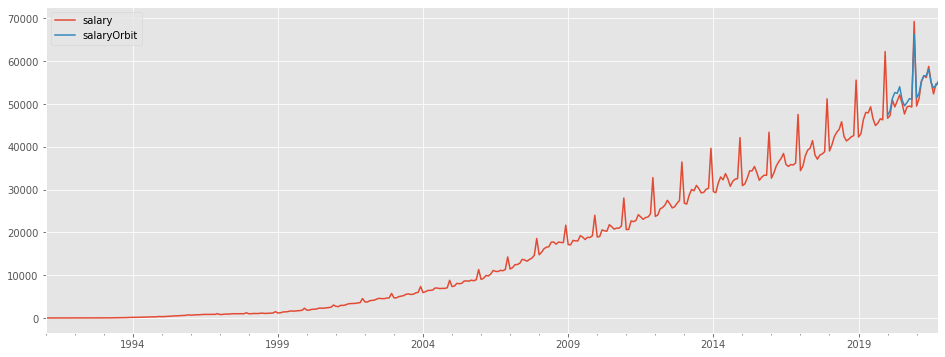

In [ ]:
df['salaryOrbit']=predicted_df.set_index('index')[['prediction']]

df[['salary', 'salaryOrbit']].plot()

In [ ]:
model_Orbit_RMSE = np.sqrt(mean_squared_error(df.loc[query_test].salary, df.loc[query_test].salaryOrbit))

In [ ]:
Results.loc[6,"Model"] = "Orbit"
Results.loc[6,"RMSE"] = model_Orbit_RMSE

Results

,Model,RMSE
0,Mean,35779.40
1,Linear,9822.31
2,ARIMA,7826.12
3,AVTOARIMA,2764.42
4,ExpSmt,4797.04
5,Prophet,1861.67
6,Orbit,1494.36


In [ ]:
from orbit.models.dlt import DLT

# инициализируем модель
dlt = DLT(
    response_col='salary', 
    date_col='index',
    regressor_col=['NDAQ'],
    seasonality=12,
)


# обучаем модель
dlt.fit(df=df.loc[query_train].reset_index())

# делаем прогноз
predicted_df = dlt.predict(df=df.loc[query_test].reset_index())

# выводим таблицу прогноза
predicted_df.head()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_05ff738ef22ce2e8a332ce639cee65cf NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,index,prediction_5,prediction,prediction_95
0,2020-01-31,46280.70,46840.48,47418.74
1,2020-02-29,47180.73,47835.19,48482.14
2,2020-03-31,49880.32,50724.73,51686.23
3,2020-04-30,51197.09,51891.59,52883.11
4,2020-05-31,50770.56,51693.65,52877.62


<AxesSubplot:>

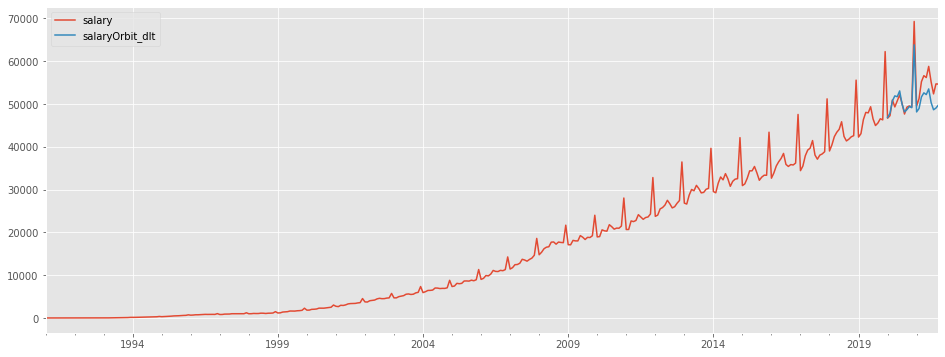

In [ ]:
df['salaryOrbit_dlt']=predicted_df.set_index('index')[['prediction']]

df[['salary', 'salaryOrbit_dlt']].plot()

In [ ]:
model_Orbit_dlt_RMSE = np.sqrt(mean_squared_error(df.loc[query_test].salary, df.loc[query_test].salaryOrbit_dlt))

In [ ]:
Results.loc[7,"Model"] = "Orbit_dlt"
Results.loc[7,"RMSE"] = model_Orbit_dlt_RMSE

Results

,Model,RMSE
0,Mean,35779.40
1,Linear,9822.31
2,ARIMA,7826.12
3,AVTOARIMA,2764.42
4,ExpSmt,4797.04
5,Prophet,1861.67
6,Orbit,1494.36
7,Orbit_dlt,3102.91


<AxesSubplot:ylabel='Model'>

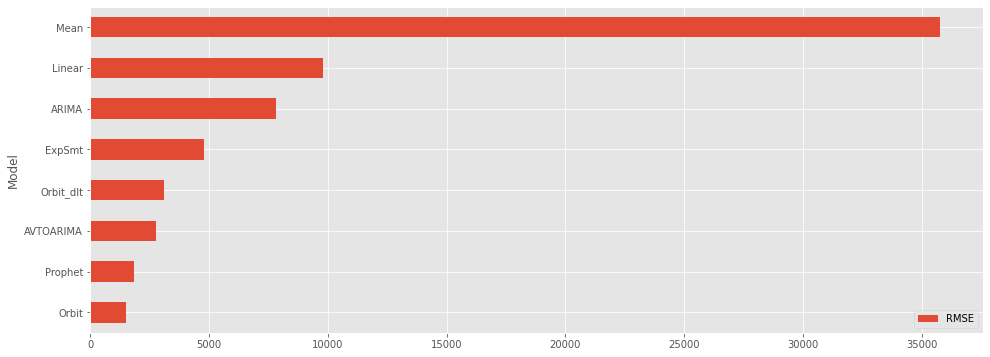

In [ ]:
Results.sort_values('RMSE').plot(kind='barh', x='Model')

![](http://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/09/image6-e1536165830511.png)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df.index
y = df['salary']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

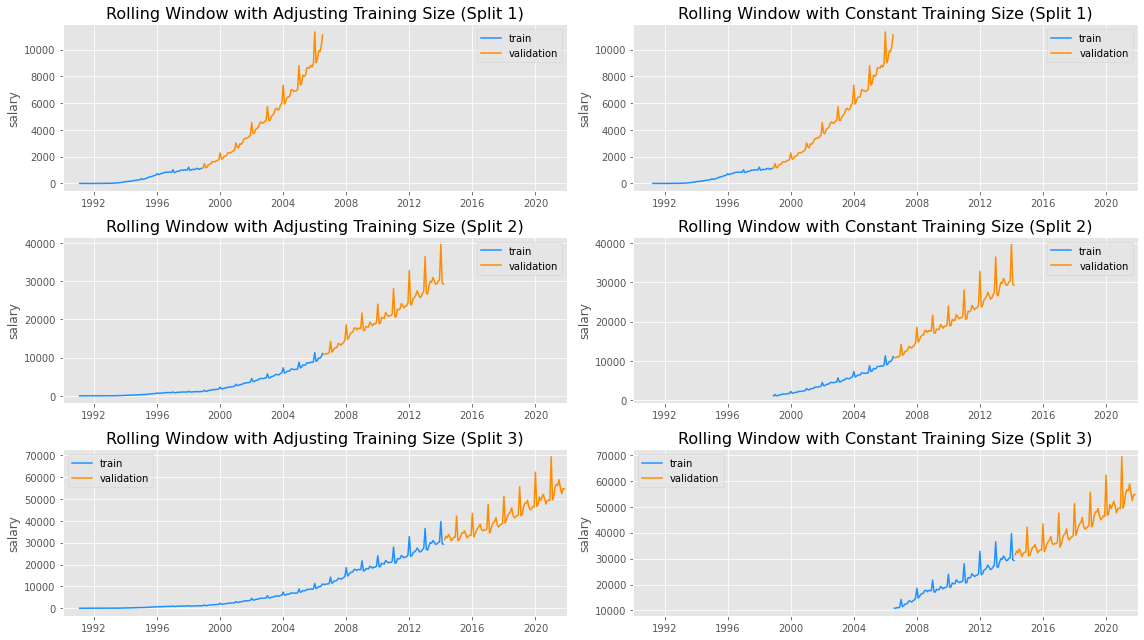

In [ ]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([pd.to_datetime('1990-01-01'), pd.to_datetime('2022-01-01')])
    ax[i, 1].set_xlim([pd.to_datetime('1990-01-01'), pd.to_datetime('2022-01-01')])


plt.tight_layout()
plt.show()